In [1]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

In [2]:
from Networks import *


C:\Users\Anka\.conda\envs\ChbCapture\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
from Utility import *

In [4]:
from matplotlib import pyplot as plt

In [12]:
saveFolder = r'F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Save'
saveName = r'N02_UVExtractor_DeepLabStructure_SingleMarker_epoch_003900.ckpt'

dataFolder = r'F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Data'
numMarkers = 50
markerSelected = 49

numTest = 200


In [6]:
imgsPerMarker, uvsPerMarker = loadDataV1(dataFolder, numMarkers, markerSelected)
trainData, trainUV, testData, testUV, numData = divideTrainValSet(imgsPerMarker[markerSelected], uvsPerMarker[markerSelected], numTest)

numTrain = numData - numTest
print('trainData: ', trainData.shape)
print('trainUV: ', trainUV.shape)
print('testData: ', testData.shape)
print('testUV: ', testUV.shape)

trainData:  (800, 60, 60, 3)
trainUV:  (800, 60, 60, 2)
testData:  (200, 60, 60, 3)
testUV:  (200, 60, 60, 2)


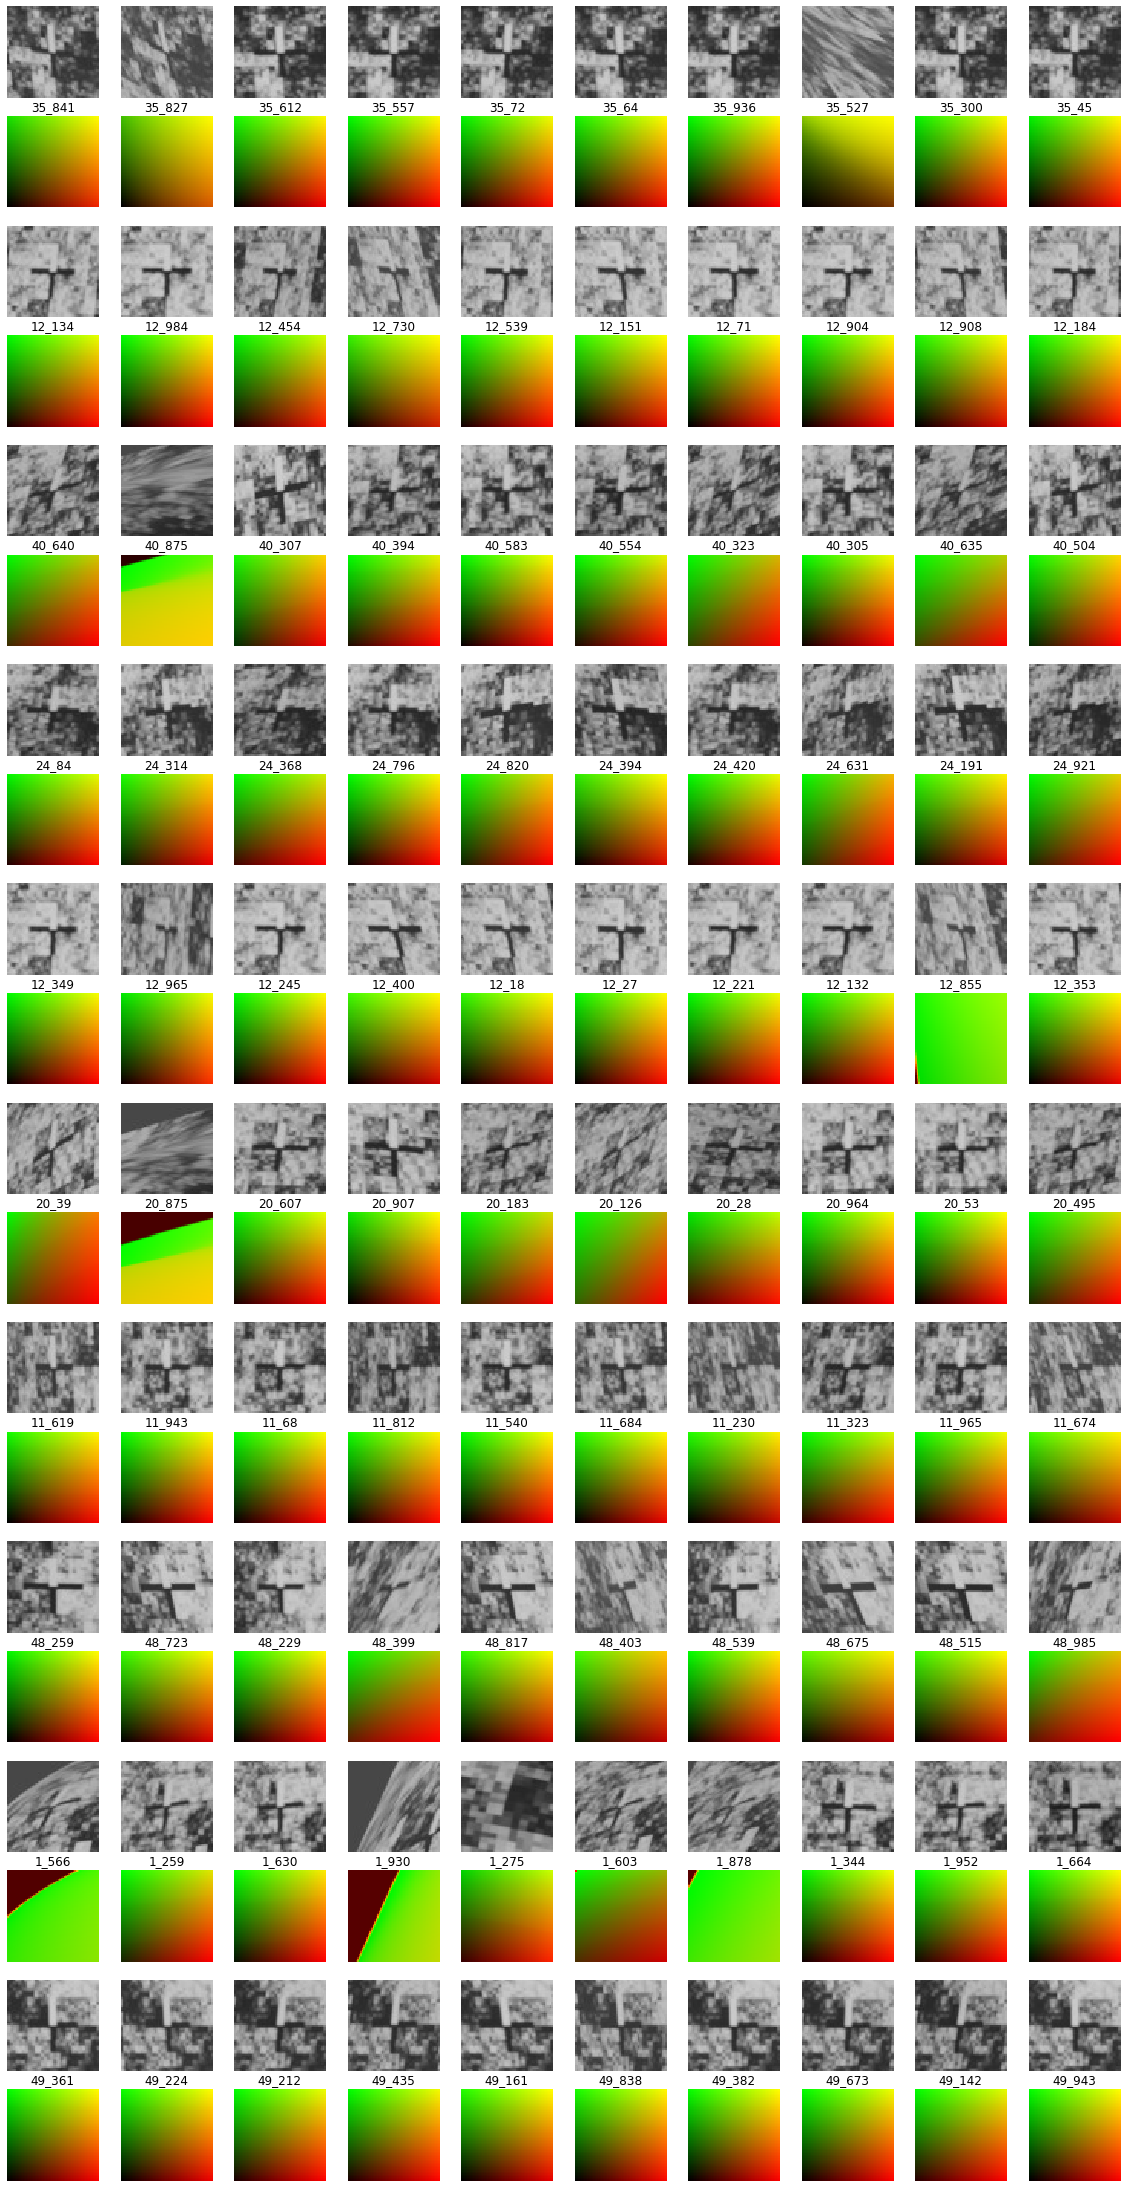

In [7]:
gridH = 20
gridW = 10
fig, axs = plt.subplots(gridH, gridW)


fig.set_size_inches(20, 20*(gridH/gridW))
for i, iMarker in enumerate(range(int(gridH/2))):
    marker = np.random.randint(0, len(imgsPerMarker))
    imgIds = np.random.randint(0, len(imgsPerMarker[marker]), size=(gridW,))
    for j, iImg in enumerate(imgIds):
        axs[i*2, j].imshow(imgsPerMarker[marker][iImg, ...], cmap="gray")
        axs[i*2, j].axis('off')
    
        axs[i*2+1, j].imshow(predToRGB(uvsPerMarker[marker][iImg, ...], normalize=True))
        axs[i*2+1, j].set_title("%d_%d" % (marker, iImg))
        axs[i*2+1, j].axis('off')
        
plt.show()

In [8]:
uvExtractor = UVExtractor('resnet_50', training=True,)

In [22]:
def evaluation(imgs, uvs, uvExtractor, imgsToShow='maxErr', numImgs=10):
    predictions = uvExtractor.predict(imgs, )
    
    evalStatistics = evaluatePrediction(predictions, uvs)
    for k, v in evalStatistics.items():
        if k != 'PerImageMeanErr' and k != 'ErrorsAll':
            print(k, v)
            
    n_bins = 50
    # We can set the number of bins with the `bins` kwarg
    plt.figure()
    kwargs = dict(alpha=0.5,  stacked=True)

    # linear
    allErrs = evalStatistics['ErrorsAll'].flatten()
    hist, bins = np.histogram(allErrs, bins=n_bins)
    bins = np.logspace(np.log10(bins[0]+1e-4), np.log10(bins[-1]), len(bins))

    # # linear
    # kwargs = dict(alpha=0.5, bins=400, stacked=True)
    # # fig = plt.figure(constrained_layout=True, tight_layout=True)
    # plt.rcParams["figure.figsize"] = (6, 2.5)  # (w, h)
    # fig = plt.figure(tight_layout=True)
    # # gs = GridSpec(1, 1, figure=fig)

    # linear
    plt.hist(allErrs, **kwargs, color='b',  bins=bins)
    plt.gca().set(ylabel='Bin count', xlabel='Prediction Errors')

    # plt.yscale('log')
    plt.xscale('log')

    # Visualize 10 frames with highest prediction error
    gridH = numImgs
    gridW = 4
    
    if imgsToShow == 'maxErr':
        imgIds10HighestMeanErrs = np.argsort(evalStatistics['PerImageMeanErr'])[-gridH:]
    elif imgsToShow == 'random':
        imgIds10HighestMeanErrs = np.random.choice(evalStatistics['PerImageMeanErr'].shape[0], gridH)
        
    fig, axs = plt.subplots(gridH, gridW)

    fig.set_size_inches(20, 20*(gridH/gridW))
    for i, iImg in enumerate(imgIds10HighestMeanErrs):
        img = imgs[iImg, ...]
        pred = predictions[iImg, ...]
        gd = uvs[iImg, ...]
        errs = evalStatistics['ErrorsAll'][iImg, ...]

        predRGB, gdRGB = predAndGdToRGB(pred, gd, normalize=True)

        axs[i, 0].imshow(img)
    #     axs[i, j].set_title("%d_%d" % (marker, iImg))
        axs[i, 0].axis('off')

        axs[i, 1].imshow(predRGB)
        axs[i, 1].axis('off')

        axs[i, 2].imshow(gdRGB)
        axs[i, 2].axis('off')

        pos=axs[i, 3].imshow(errs, cmap='jet')
        axs[i, 3].legend()
        axs[i, 3].axis('off')                         
        fig.colorbar(pos, ax=axs[i, 3]) 
        axs[i, 3].set_title("Mean Err: %f" % (evalStatistics['PerImageMeanErr'][iImg]))


    plt.show()

In [14]:
loadWeights = True

if loadWeights:
    saver = tf.train.Saver()
    saver.restore(uvExtractor.sess, join(saveFolder, saveName))
else:
    init = tf.global_variables_initializer()
    sess.run(init)

INFO:tensorflow:Restoring parameters from F:\WorkingCopy2\2021_03_01_RandomlyDeformedGridMesh\Save\N02_UVExtractor_DeepLabStructure_SingleMarker_epoch_003900.ckpt


MeanErr 0.002115557255441965
MedianErr 0.0015967587076419283
MaxErr 0.16126332653810166
Error95Percentile 0.004526797436103904
Error99Percentile 0.015486946681684974
Error999Percentile 0.0387572224459065
Error9999Percentile 0.0715055522278699


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB

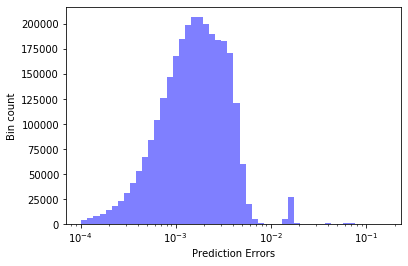

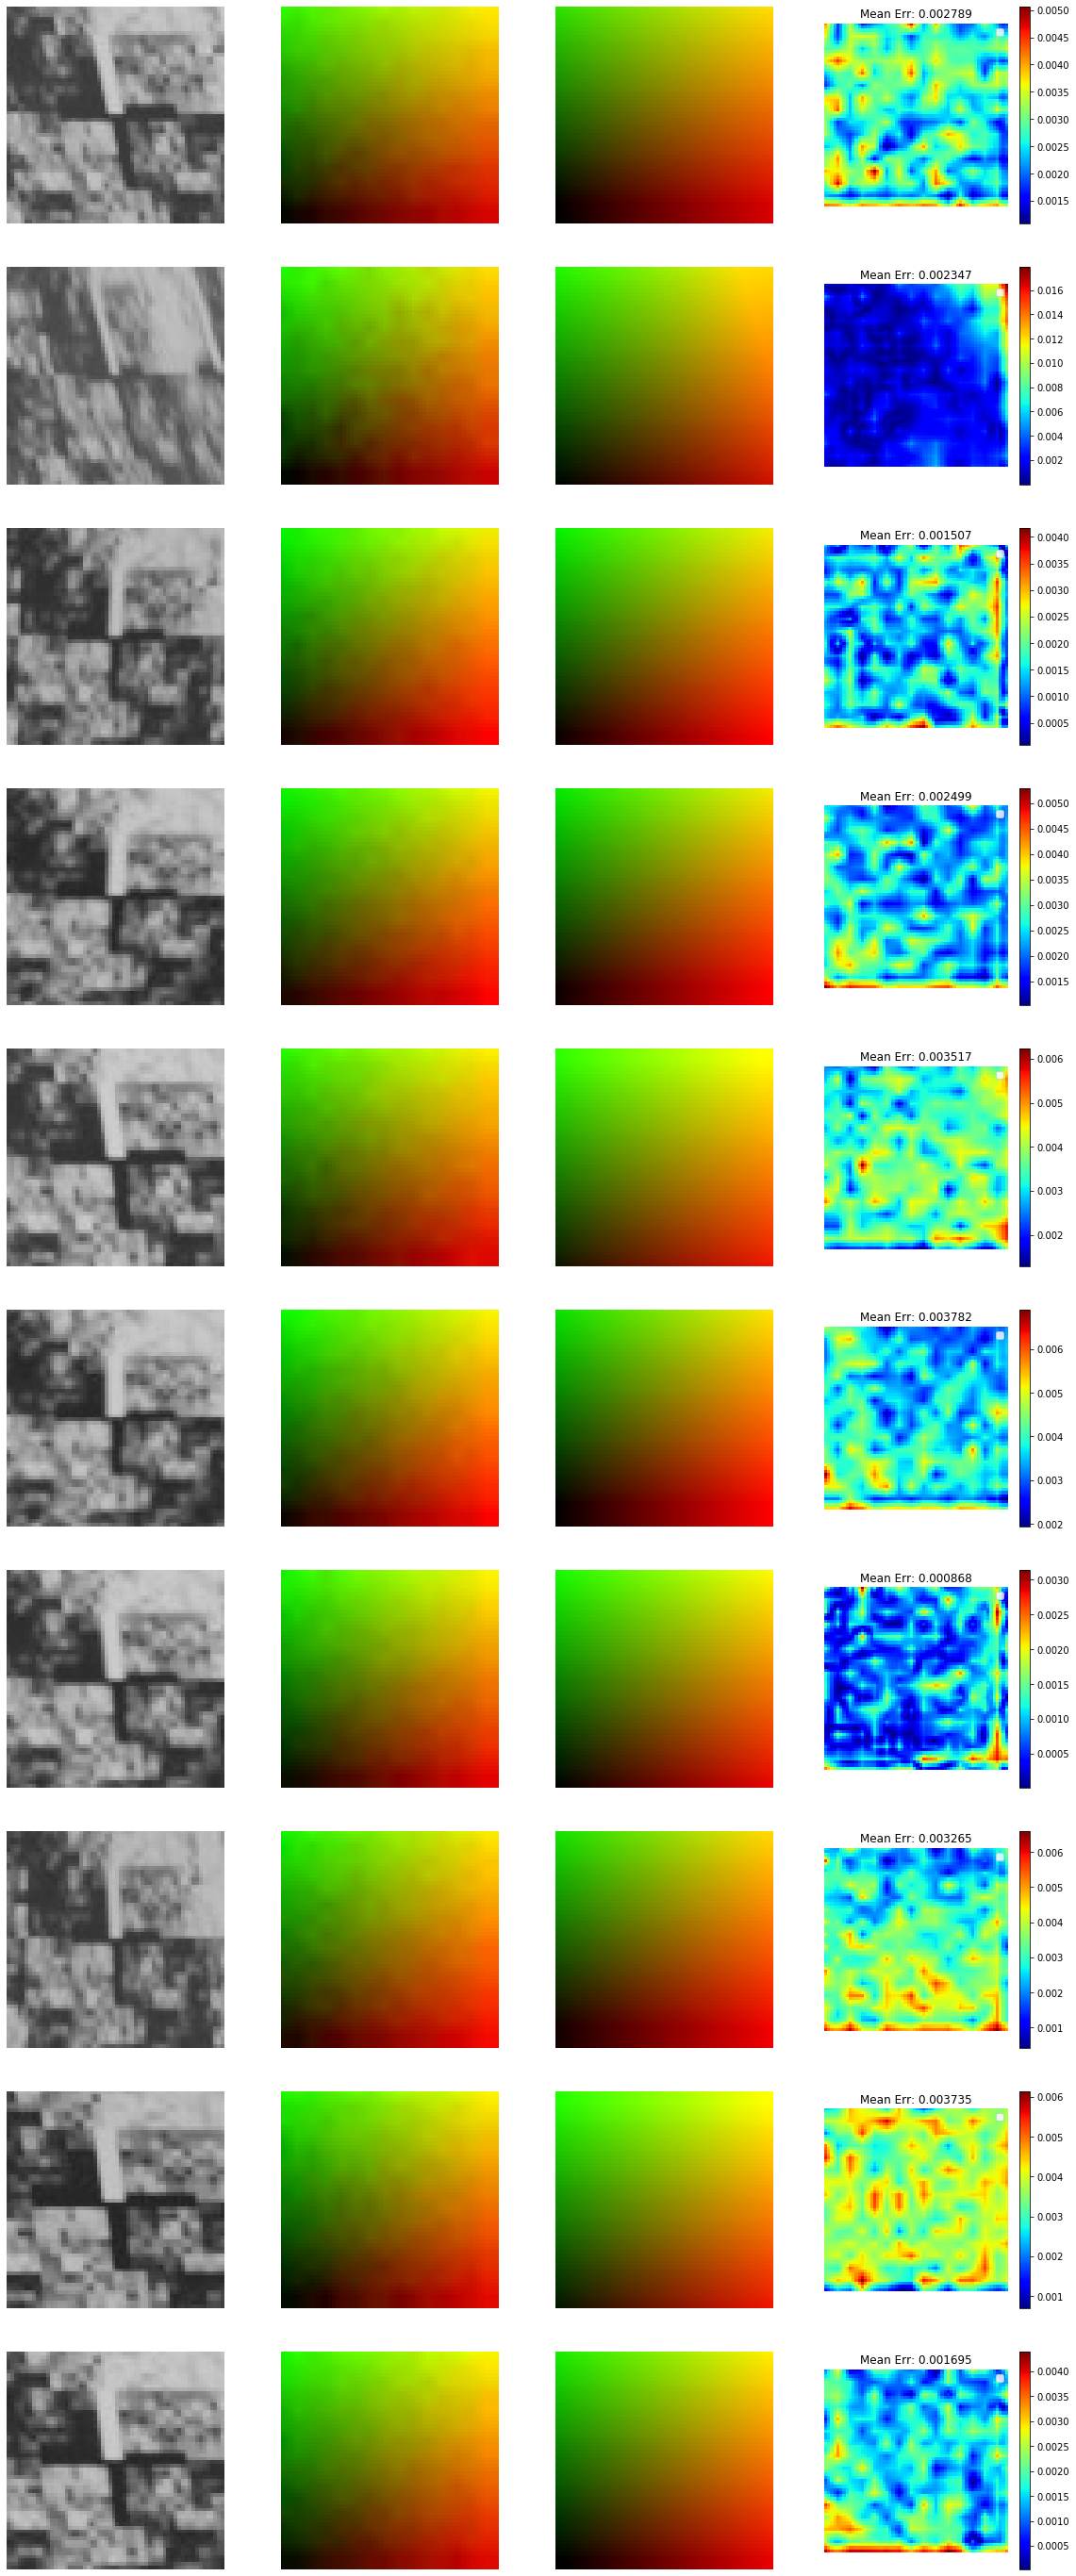

In [24]:
evaluation(trainData, trainUV, uvExtractor, imgsToShow='random')

MeanErr 0.0035881634080519404
MedianErr 0.0024488689796510706
MaxErr 0.2587249361570525
Error95Percentile 0.009866319594300219
Error99Percentile 0.013451512015251707
Error999Percentile 0.17543006651665347
Error9999Percentile 0.23888395184314018


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
No handles with labels found to put in legend.
Clipping input data to the valid range for imshow with RGB

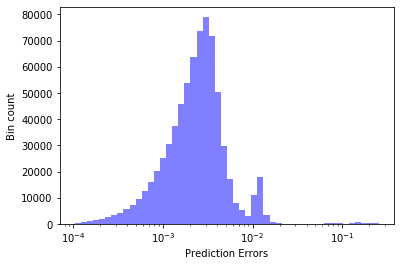

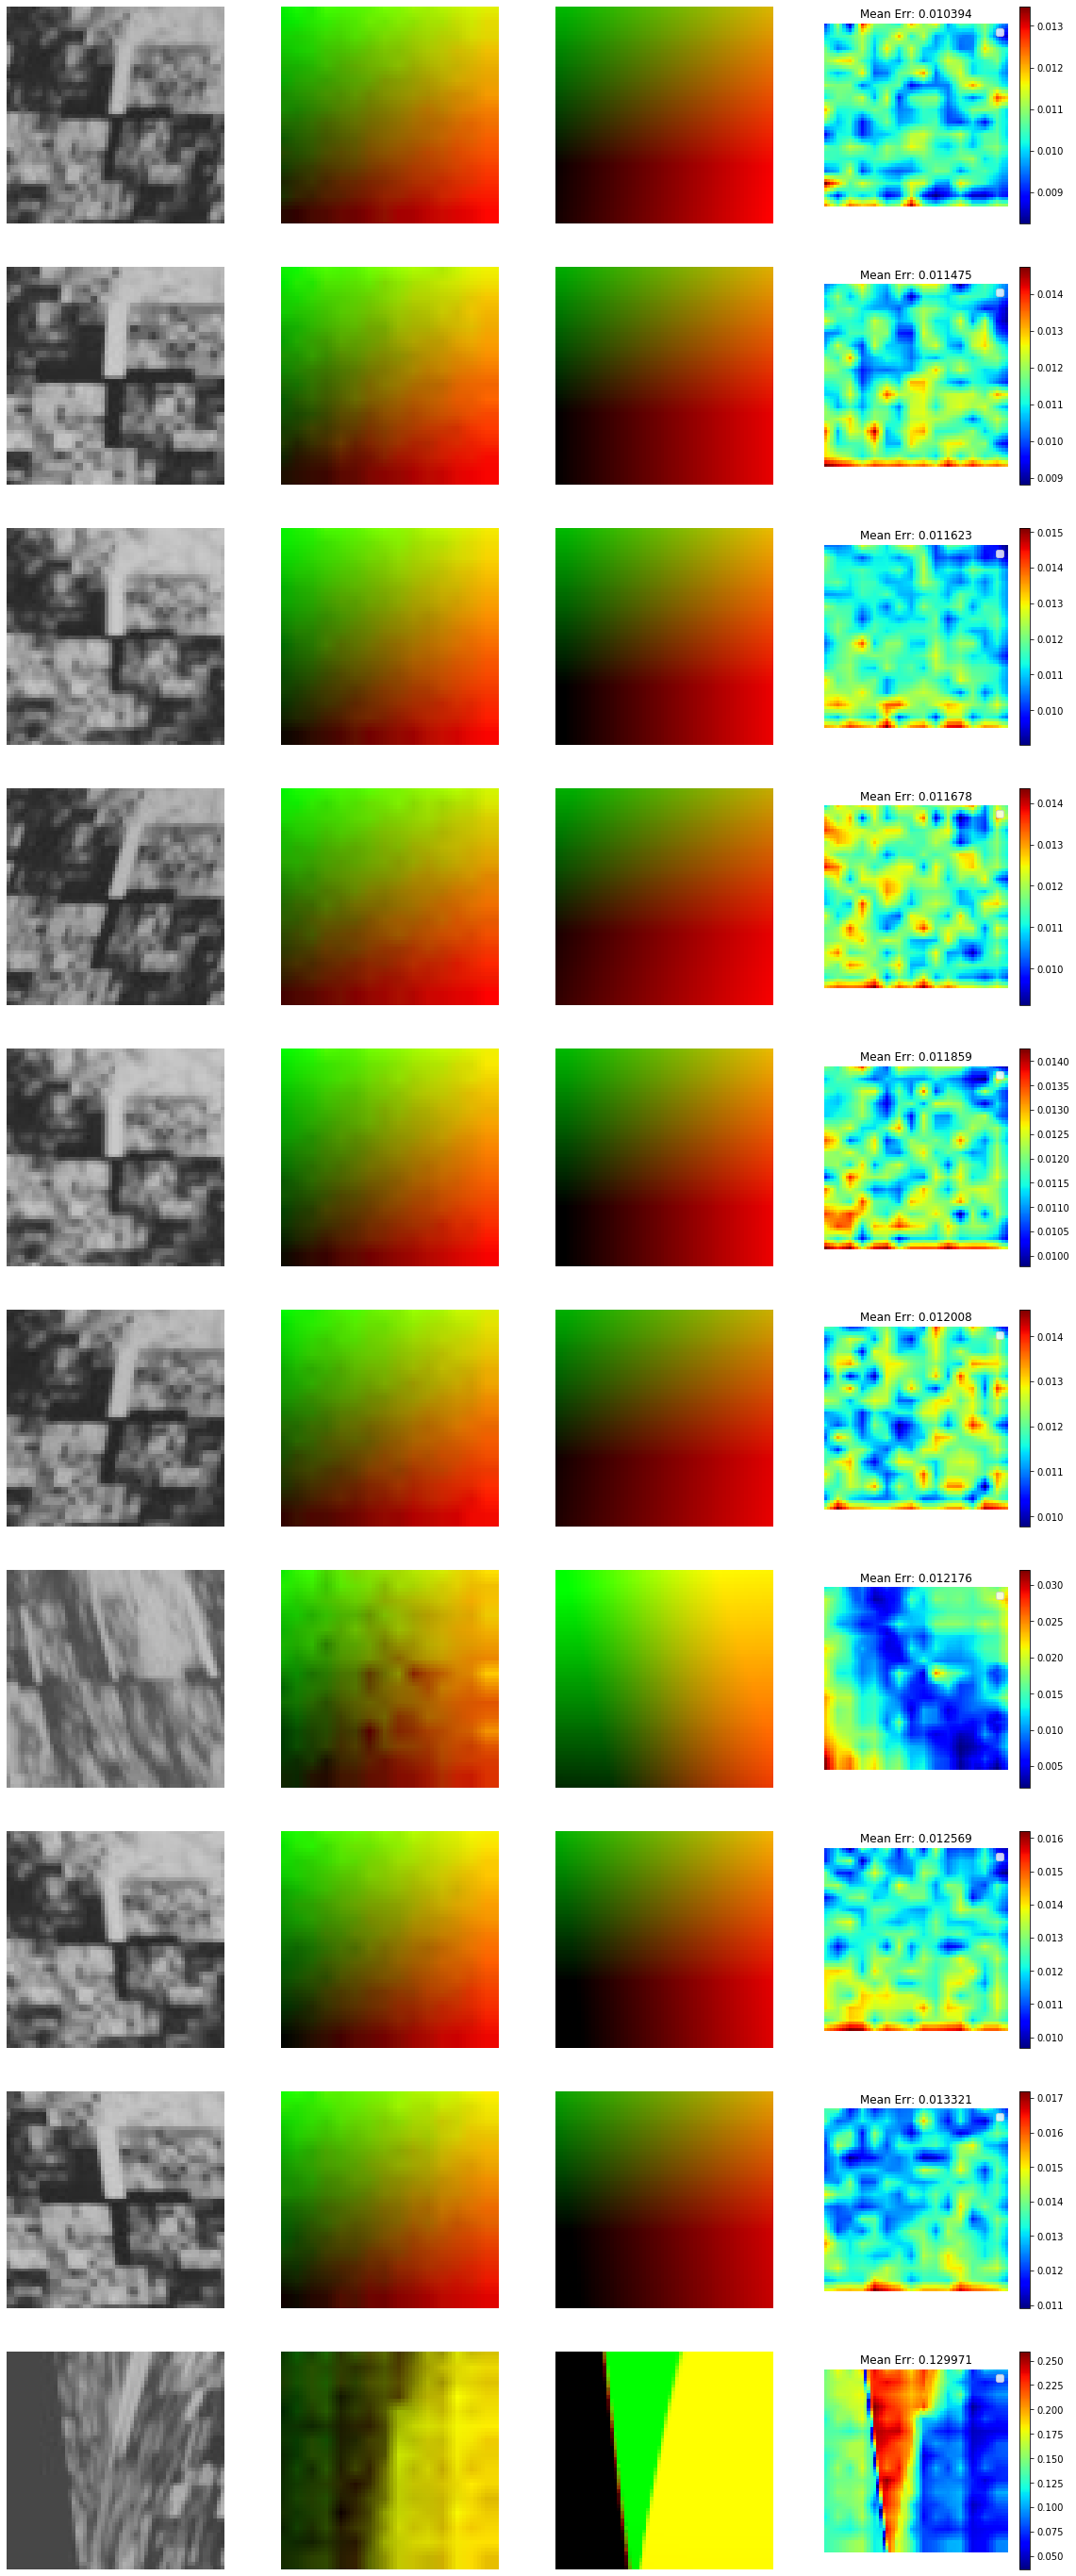

In [23]:
evaluation(testData, testUV, uvExtractor)